Importation des packages

In [194]:
!pip install py7zr geojson geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette

  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-qiabzccq
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-qiabzccq
  Resolved https://github.com/inseefrlab/cartiflette to commit f6b0c5d049bd6dcae7b437bd931957371da24278
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [195]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geojson
import requests
import time
import os
import re
import magic
import matplotlib.pyplot as plt
import zipfile
import cartiflette
from io import StringIO
import statsmodels.formula.api as sm

In [196]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV


On veut d'abord récupérer les données de la base DVF à partir de l'API publique dédiée. On peut regarder la documentation de cette API sur le site suivant : 
https://apidf-preprod.cerema.fr/swagger/#/DVF%2B%20(acc%C3%A8s%20libre)/dvf_opendata_geomutations_list


I. Importation des données DVF

A. Paramétrage de l'API

On écrit la racine de l'API : 

In [197]:
base_api_dvf_url = "https://apidf-preprod.cerema.fr"

On va récupérer les données DVF des villes suivantes : 
1. Zone ouest :
- Paris 16 : 75116
- Paris 17: 75117
- Clichy : 92024
- Levallois : 92044
- Neuilly : 92051
- Boulogne-Billancourt : 92012

2. Zone sud
- Paris 13 : 75113
- Paris 14 : 75114
- Paris 15 : 75115
- Issy-les-Moulineaux : 92040
- Vanves : 92075
- Malakoff : 92046
- Montrouge : 92049
- Gentilly : 94037
- Ivry-sur-Seine : 94041


On constate en faisant tourner naïvement l'API qu'on obtient toujours des données par paquets en nombre limité (par défaut, 100). On peut modifier cela par le paramètre "page_size", mais la limite est de 500. Pour un paramètre supérieur à 500, on n'obtient que des pages de 500. 

On cherche donc à faire boucler nos requêtes à l'API jusqu'à obtenir toutes les données concernant la commune qui nous intéresse. Or on constate que la réponse "data" que l'on obtient possède une clé "next", qui donne l'url de notre requête complété par un argument "page". L'API fonctionne donc ainsi : s'il y a plus de 500 observations pour une commune, l'API nous renvoie une première page qui contient 500 observations, avec l'url pour requêter la page suivant qui contient 500 autres observations, et ainsi de suite jusqu'à la dernière page, qui donne pour valeur "None" à la clé "next". 

Le code ci-dessous permet de récupérer les données.

In [198]:
"""data_dvf_sud = recup_donnees_dvf("92040",2014) 

code_insee_ville_banlieue_sud = ["92040", "92075", "92046", "92049", "94037", "94041"]
code_insee_arrond_sud = ["75113", "75114", "75115"]

for code_insee_ville in code_insee_ville_banlieue_sud: 
    print(code_insee_ville)
    for annee in range(2013,2022):
        print(annee)
        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))
        data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)

data_dvf_sud.shape"""

'data_dvf_sud = recup_donnees_dvf("92040",2014) \n\ncode_insee_ville_banlieue_sud = ["92040", "92075", "92046", "92049", "94037", "94041"]\ncode_insee_arrond_sud = ["75113", "75114", "75115"]\n\nfor code_insee_ville in code_insee_ville_banlieue_sud: \n    print(code_insee_ville)\n    for annee in range(2013,2022):\n        print(annee)\n        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))\n        data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)\n\ndata_dvf_sud.shape'

In [199]:
"""data_dvf_sud = recup_donnees_dvf_all_years("92040") 

code_insee_ville_banlieue_sud = ["92075", "92046", "92049", "94037", "94041"]
code_insee_arrond_sud = ["75113", "75114", "75115"]

for code_insee_ville in code_insee_ville_banlieue_sud: 
    print(code_insee_ville)
    data_temp = recup_donnees_dvf_all_years(code_insee_ville)
    data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)

data_dvf_sud.shape"""

'data_dvf_sud = recup_donnees_dvf_all_years("92040") \n\ncode_insee_ville_banlieue_sud = ["92075", "92046", "92049", "94037", "94041"]\ncode_insee_arrond_sud = ["75113", "75114", "75115"]\n\nfor code_insee_ville in code_insee_ville_banlieue_sud: \n    print(code_insee_ville)\n    data_temp = recup_donnees_dvf_all_years(code_insee_ville)\n    data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)\n\ndata_dvf_sud.shape'

In [200]:
#data_dvf_sud.shape

Difficulté : l'API peut arrêter de nous répondre de manière imprévue au milieu de la boucle de requête des pages. Dans ce cas, toutes les données obtenues sur les pages précédentes sont perdues. On a donc intérêt, pour pouvoir travailler sereinement, à télécharger ces données. 

Pour ce faire, on va essayer, commune par commune, de requêter toutes les pages, et, AVANT de passer au requêtage pour la commune suivante, on sauvegarde notre geodataframe au format geojson. 

In [201]:
"""code_insee_pour_enregistre = ["92012"]
for code_insee in code_insee_pour_enregistre: 
    url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=100"
    response = requests.get(url)
    data = response.json()
    print(data['count'])
    gdf = recup_donnees_dvf_all_years(code_insee)
    name = f'data/dvf/data_code_insee={code_insee}.geojson'
    gdf.to_file(name, driver="GeoJSON")
    gdf = gpd.read_file(name)
    print(len(gdf))"""

'code_insee_pour_enregistre = ["92012"]\nfor code_insee in code_insee_pour_enregistre: \n    url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=100"\n    response = requests.get(url)\n    data = response.json()\n    print(data[\'count\'])\n    gdf = recup_donnees_dvf_all_years(code_insee)\n    name = f\'data/dvf/data_code_insee={code_insee}.geojson\'\n    gdf.to_file(name, driver="GeoJSON")\n    gdf = gpd.read_file(name)\n    print(len(gdf))'

On fait pareil pour la zone ouest de Paris

In [202]:
"""data_dvf_ouest_banlieue = recup_donnees_dvf("92040",2014) 

code_insee_ville_banlieue_ouest = ["92040", "92075", "92046", "92049", "94037", "94041"]

for code_insee_ville in code_insee_ville_banlieue_ouest: 
    print(code_insee_ville)
    for annee in range(2013,2022):
        print(annee)
        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))
        data_dvf_ouest = pd.concat([data_dvf_ouest, data_temp], axis = 0)

data_dvf_ouest_banlieue.shape"""

'data_dvf_ouest_banlieue = recup_donnees_dvf("92040",2014) \n\ncode_insee_ville_banlieue_ouest = ["92040", "92075", "92046", "92049", "94037", "94041"]\n\nfor code_insee_ville in code_insee_ville_banlieue_ouest: \n    print(code_insee_ville)\n    for annee in range(2013,2022):\n        print(annee)\n        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))\n        data_dvf_ouest = pd.concat([data_dvf_ouest, data_temp], axis = 0)\n\ndata_dvf_ouest_banlieue.shape'

In [203]:
"""data_dvf_ouest_paris = recup_donnees_dvf("75116",2012)

code_insee_arrond_ouest = ["75116", "75117"]

for code_insee_ville in code_insee_arrond_ouest: 
    print(code_insee_ville)
    for annee in range(2013,2022):
        print(annee)
        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))
        data_dvf_ouest_paris = pd.concat([data_dvf_ouest_paris, data_temp], axis = 0)
"""

'data_dvf_ouest_paris = recup_donnees_dvf("75116",2012)\n\ncode_insee_arrond_ouest = ["75116", "75117"]\n\nfor code_insee_ville in code_insee_arrond_ouest: \n    print(code_insee_ville)\n    for annee in range(2013,2022):\n        print(annee)\n        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))\n        data_dvf_ouest_paris = pd.concat([data_dvf_ouest_paris, data_temp], axis = 0)\n'

Ci-dessous, le code pour reconstituer les fichiers geojson à partir des sauvegardes faites à cause de l'API défectueuse (en deux temps : la zone ouest puis la zone sud)

In [204]:
obs_tot = 0
list_gpd_ouest = []
for geo_file in os.listdir("data/dvf/cluster_ouest"): 
    geo_file_temp = gpd.read_file("data/dvf/cluster_ouest/"+geo_file)  
    list_gpd_ouest.append(geo_file_temp)
    obs_tot += len(geo_file_temp)

all_gpd_ouest = pd.concat(list_gpd_ouest)
print(len(all_gpd_ouest), obs_tot)

134410 134410


In [205]:
obs_tot = 0
list_gpd_sud = []
for geo_file in os.listdir("data/dvf/cluster_sud"): 
    geo_file_temp = gpd.read_file("data/dvf/cluster_sud/"+geo_file)  
    obs_tot += len(geo_file_temp)
    list_gpd_sud.append(geo_file_temp)

all_gpd_sud = pd.concat(list_gpd_sud)
print(len(all_gpd_sud), obs_tot)

119319 119319


II. Récupération de données Insee par IRIS pour avoir des variables de contrôle dans notre régression

Il n'y a pas d'API permettant de récupérer les données voulues par IRIS, donc on doit passer par l'importation de tous les fichiers. On importe trois types de fichiers : un qui contient des informations sur le revenu disponible ('BASE_TD_FILO_DISP_IRIS), un qui donne des informations sur les logements ('base_ic_logement') et un sur les occupations professionnelles des habitants de l'IRIS ('base-ic-activite-residents').

In [206]:
dfs_activite = []
dfs_logement = []
dfs_revenu = []
dates_df = []


for f in os.listdir("data/insee"):
    if f.lower().endswith(".zip"): #si c'est un zip
        print(f)
        zip_file = zipfile.ZipFile("data/insee/"+f) #on le dézipe
        nom_racine_dossier = f.rsplit(".",1)[0]
        for f_in_zip in zipfile.ZipFile("data/insee/"+f).namelist():
            if f_in_zip[0:4] == "meta" :
                pass
            else :
                nom_racine_fichier = f_in_zip.rsplit(".",1)[0]
                extension = f_in_zip.rsplit(".",1)[1] #on récupère l'extension
                
                # Recherche de l'année
                schema_date = r"(\d{4})"
                match = re.search(schema_date, f)
                    
                annee_extraite = match.group(1)
                
                if extension.lower() == "csv":
                    df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), 
                                            sep = ";", dtype = {'IRIS' : str})
                                            
                elif extension in ("xls", "xlsx"):
                    df_temp = pd.read_excel(zip_file.open(nom_racine_fichier + "." + extension),
                                            skiprows = 5, dtype = {'IRIS' : str})
                    
                df_temp['IRIS'] = df_temp['IRIS'].apply(lambda x: '0' + x if len(x) == 8 else x)
                
                deux_derniers_chiffres_annee = annee_extraite[2:4]
                df_temp['annee'] = annee_extraite
                
                if "activite" in nom_racine_fichier:
                    df_temp.columns = [col.replace(f'{deux_derniers_chiffres_annee}_', '_') for col in df_temp.columns]
                    dfs_activite.append(df_temp)
                elif "logement" in nom_racine_fichier:
                    df_temp.columns = [col.replace(f'{deux_derniers_chiffres_annee}_', '_') for col in df_temp.columns]
                    dfs_logement.append(df_temp)
                elif "DISP" in nom_racine_fichier:
                    colonnes_a_traiter = [col for col in df_temp.columns if col.endswith(deux_derniers_chiffres_annee)]
                    df_temp = df_temp.rename(columns={col: col[:-2] for col in colonnes_a_traiter})
                    dfs_revenu.append(df_temp)
                else :
                    print('un fichier n a pas été traité')

                dates_df.append(annee_extraite)
    else :
        nom_racine_fichier = f.rsplit(".",1)[0]
        extension = f.rsplit(".",1)[1] #on récupère l'extension
                
        schema_date = r"(\d{4})"
        match = re.search(schema_date, f)     
        annee_extraite = match.group(1)

        df_temp = pd.read_excel("data/insee/" + nom_racine_fichier + "." + extension,
                                            skiprows = 5, dtype = {'IRIS' : str})
                    
        df_temp['IRIS'] = df_temp['IRIS'].apply(lambda x: '0' + x if len(x) == 8 else x)
        deux_derniers_chiffres_annee = annee_extraite[2:4]
        df_temp['annee'] = annee_extraite
                
        if "DISP" in nom_racine_fichier:
            colonnes_a_traiter = [col for col in df_temp.columns if col.endswith(deux_derniers_chiffres_annee)]
            df_temp = df_temp.rename(columns={col: col[:-2] for col in colonnes_a_traiter})
            dfs_revenu.append(df_temp)

        dates_df.append(annee_extraite)


base-ic-logement-2018_csv.zip


/tmp/ipykernel_295902/2103325727.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-logement-2015.zip
base-ic-activite-residents-2021_csv.zip


/tmp/ipykernel_295902/2103325727.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


BASE_TD_FILO_DISP_IRIS_2018.zip
base-ic-activite-residents-2015.zip
base-ic-logement-2016.zip
base-ic-logement-2017_csv.zip


/tmp/ipykernel_295902/2103325727.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


BASE_TD_FILO_DISP_IRIS_2020_CSV.zip
base-ic-activite-residents-2019_csv.zip


/tmp/ipykernel_295902/2103325727.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2020_csv.zip


/tmp/ipykernel_295902/2103325727.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2016.zip
base-ic-logement-2019_csv.zip


/tmp/ipykernel_295902/2103325727.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2017_csv.zip


/tmp/ipykernel_295902/2103325727.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2018_csv.zip


/tmp/ipykernel_295902/2103325727.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-logement-2020_csv.zip


/tmp/ipykernel_295902/2103325727.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-logement-2014.zip
base-ic-logement-2021_csv.zip


/tmp/ipykernel_295902/2103325727.py:26: DtypeWarning: Columns (1,3,80,81,82,83,84,85,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


BASE_TD_FILO_DISP_IRIS_2019.zip
BASE_TD_FILO_IRIS_2021_DISP_CSV.zip
base-ic-activite-residents-2014.zip
BASE_TD_FILO_DISP_IRIS_2020_XLSX.zip


In [207]:
dfs_clean_activite = pd.concat(dfs_activite, ignore_index = True)
dfs_clean_revenu = pd.concat(dfs_revenu, ignore_index = True)
dfs_clean_logement = pd.concat(dfs_logement, ignore_index = True)

In [208]:
print(dfs_clean_activite.shape)
print(dfs_clean_revenu.shape)
print(dfs_clean_logement.shape)


(395824, 131)
(122018, 36)
(395824, 123)


In [209]:
df_fusion_inter = pd.merge(dfs_clean_activite, dfs_clean_revenu,how = "outer", on=['IRIS','annee']) 
df_fusion_all_insee = pd.merge(df_fusion_inter, dfs_clean_logement, how = "outer",on=['IRIS', 'annee'])#, 'LIBIRIS','TYP_IRIS','MODIF_IRIS','LAB_IRIS','COM', 'LIBCOM'])

Vérifions que le dataframe obtenu n'a pas de problème.

In [210]:
print(df_fusion_inter.shape)
print(df_fusion_all_insee.shape)

(411921, 165)
(411921, 286)


III. Fusion de nos deux jeux de données


Troisième et dernière étape d'importation des données : un fichier pour faire la correspondance entre les adresses/coordonnées des données DVF et les IRIS des données Insee.

On utilise un fichier des données géographiques des IRIS d'Île-de-France.

In [211]:
iris = gpd.read_file("data/iris.geojson")  
iris = iris.to_crs(epsg=4326)  # Assurez-vous d'utiliser le même système de coordonnées (WGS84)
iris['code_iris'] = iris['code_iris'].astype(str)

On regarde dans quel système géographique est le tableau geopandas des données DVF

In [212]:
print(all_gpd_sud["geometry"].crs)
print(all_gpd_ouest["geometry"].crs)

EPSG:4326
EPSG:4326


Ok, on est bien en format 4326 (=WGS 84) pour les deux fichiers, on va pouvoir affecter des IRIS à nos adresses de la base DVF (pour ensuite relier ça aux fichiers Insee)

In [213]:
data_mut_sud_avec_iris = gpd.sjoin(all_gpd_sud, iris, how="left", predicate="intersects")
data_mut_ouest_avec_iris = gpd.sjoin(all_gpd_ouest, iris, how="left", predicate="intersects")

# Vérifier les résultats
print(data_mut_sud_avec_iris.head())
print(data_mut_sud_avec_iris.columns)
print(all_gpd_sud.shape)
print(data_mut_sud_avec_iris.shape)

                         idmutinvar                        idopendata  \
0  95a6760ed10c9de595b655e8f1db703f  95a6760ed10c9de595b655e8f1db703f   
1  4a37e862dcb628c7b473b474b6dbb3ed  4a37e862dcb628c7b473b474b6dbb3ed   
2  9711e8d4ccc5c4dfa867545f65cc28c3  9711e8d4ccc5c4dfa867545f65cc28c3   
3  ff355bdd9fdf67cc54c7d4e90bad115d  ff355bdd9fdf67cc54c7d4e90bad115d   
4  14b9a2c07cfe462e0a6a34bc3f87b6eb  14b9a2c07cfe462e0a6a34bc3f87b6eb   

     datemut anneemut coddep libnatmut   vefa valeurfonc nbcomm l_codinsee  \
0 2024-05-14     2024     92     Vente  False   38000.00      1      92049   
1 2024-02-26     2024     92     Vente  False   18000.00      1      92049   
2 2024-03-19     2024     92     Vente  False  220000.00      1      92049   
3 2024-05-27     2024     92     Vente  False  518000.00      1      92049   
4 2024-06-04     2024     92     Vente  False  540000.00      1      92049   

   ...                                           geometry index_right  \
0  ...  MULTIPOLYGO

Les deux codes ci-dessous servent à éliminer les ventes qui sont à cheval entre deux IRIS (on a assez d'observations comme ça et elles pourraient brouiller les résultats de la régression).

In [214]:
non_unique_ids_sud = data_mut_sud_avec_iris['idmutinvar'][data_mut_sud_avec_iris['idmutinvar'].duplicated(keep=False)]
data_mut_sud_avec_iris_unique = data_mut_sud_avec_iris[~data_mut_sud_avec_iris['idmutinvar'].isin(non_unique_ids_sud)]
data_mut_sud_avec_iris = data_mut_sud_avec_iris_unique

In [215]:
non_unique_ids_ouest = data_mut_ouest_avec_iris['idmutinvar'][data_mut_ouest_avec_iris['idmutinvar'].duplicated(keep=False)]
data_mut_ouest_avec_iris_unique = data_mut_ouest_avec_iris[~data_mut_ouest_avec_iris['idmutinvar'].isin(non_unique_ids_ouest)]
print(data_mut_ouest_avec_iris.shape)
print(data_mut_ouest_avec_iris_unique.shape)

data_mut_ouest_avec_iris = data_mut_ouest_avec_iris_unique

(140041, 31)
(129306, 31)


On enlève les ventes faites après 2021 car les données Insee s'arrêtent en 2021

In [216]:
data_mut_sud_avec_iris = data_mut_sud_avec_iris[data_mut_sud_avec_iris['anneemut'].astype(int) < 2022]
data_mut_sud_avec_iris.shape

data_mut_ouest_avec_iris = data_mut_ouest_avec_iris[data_mut_ouest_avec_iris['anneemut'].astype(int) < 2022]
data_mut_ouest_avec_iris.shape

(96924, 31)

Dernière étape : relier ça aux données Insee

In [217]:
data_mut_ouest_et_insee = pd.merge(left = data_mut_ouest_avec_iris,
                            right = df_fusion_all_insee, 
                            how = "inner",
                            left_on = ["code_iris", "anneemut"],
                            right_on = ["IRIS", "annee"])

data_mut_sud_et_insee = pd.merge(left = data_mut_sud_avec_iris,
                            right = df_fusion_all_insee, 
                            how = "inner",
                            left_on = ["code_iris", "anneemut"],
                            right_on = ["IRIS", "annee"])
                            

In [218]:
data_mut_ouest_et_insee.shape

(109677, 317)

Ci-dessous, on va regarder les variables des trois jeux de données Insee et vérifier qu'ils sont bien présents dans le jeu de données final (on va regarder sur 2019 car on sait qu'il y a bien pour cette année des données DVF et Insee complètes)

In [219]:
data_mut_ouest_et_insee_2019 = data_mut_ouest_et_insee[data_mut_ouest_et_insee["anneemut"] == "2019"]

In [220]:
dfs_revenu[1].columns

Index(['IRIS', 'DISP_TP60', 'DISP_Q1', 'DISP_MED', 'DISP_Q3', 'DISP_EQ',
       'DISP_D1', 'DISP_D2', 'DISP_D3', 'DISP_D4', 'DISP_D6', 'DISP_D7',
       'DISP_D8', 'DISP_D9', 'DISP_RD', 'DISP_S80S20', 'DISP_GI', 'DISP_PACT',
       'DISP_PTSA', 'DISP_PCHO', 'DISP_PBEN', 'DISP_PPEN', 'DISP_PPAT',
       'DISP_PPSOC', 'DISP_PPFAM', 'DISP_PPMINI', 'DISP_PPLOGT', 'DISP_PIMPOT',
       'DISP_NOTE', 'annee'],
      dtype='object')

In [221]:
dfs_logement[1].columns

Index(['IRIS', 'REG', 'DEP', 'UU2010', 'COM', 'LIBCOM', 'TRIRIS', 'GRD_QUART',
       'LIBIRIS', 'TYP_IRIS',
       ...
       'P_RP_TTEGOU', 'P_RP_GARL', 'P_RP_VOIT1P', 'P_RP_VOIT1', 'P_RP_VOIT2P',
       'P_RP_HABFOR', 'P_RP_CASE', 'P_RP_MIBOIS', 'P_RP_MIDUR', 'annee'],
      dtype='object', length=103)

In [222]:
dfs_activite[1].columns

Index(['IRIS', 'REG', 'DEP', 'UU2010', 'COM', 'LIBCOM', 'TRIRIS', 'GRD_QUART',
       'LIBIRIS', 'TYP_IRIS',
       ...
       'P_ACTOCC15P_ILT3', 'P_ACTOCC15P_ILT4', 'P_ACTOCC15P_ILT5',
       'C_ACTOCC15P', 'C_ACTOCC15P_PAS', 'C_ACTOCC15P_MAR', 'C_ACTOCC15P_DROU',
       'C_ACTOCC15P_VOIT', 'C_ACTOCC15P_TCOM', 'annee'],
      dtype='object', length=115)

In [223]:
print(data_mut_ouest_et_insee_2019['P_ACTOCC15P_ILT3']) #activite
print(data_mut_ouest_et_insee_2019['P_RP_VOIT1P']) #logement
print(data_mut_ouest_et_insee_2019['DISP_D1']) #revenu

10177      405.725596
10178      488.261079
10179      345.759051
10180      341.388668
10181      428.201811
             ...     
104325     392.985318
104326     782.718335
104327    1102.075466
104328     728.812234
104329    1102.075466
Name: P_ACTOCC15P_ILT3, Length: 15282, dtype: float64
10177     426.731153
10178     608.133911
10179     426.768578
10180     512.641276
10181     831.140647
             ...    
104325    470.856413
104326    822.214108
104327    837.176285
104328    841.889822
104329    837.176285
Name: P_RP_VOIT1P, Length: 15282, dtype: float64
10177     12290
10178     13460
10179     15270
10180     14240
10181     15680
          ...  
104325    11050
104326    14560
104327    14760
104328    14810
104329    14760
Name: DISP_D1, Length: 15282, dtype: object


IV. Nettoyage du jeu de données

Regardons d'abord notre jeu de données :

In [224]:
print(data_mut_ouest_et_insee.shape)

(109677, 317)


On a énormément de colonnes dans ce jeu de données, sont-elles toutes utilisables ?

In [225]:
df_verif = pd.DataFrame(data_mut_ouest_et_insee.isna().sum() / len(data_mut_ouest_et_insee)) 
print(df_verif)

                         0
idmutinvar        0.000000
idopendata        0.000000
datemut           0.000000
anneemut          0.000000
coddep            0.000000
...                    ...
P_RPMAISON_ACH11  0.895940
P_RPAPPART_ACH11  0.895940
P_RP_ACH18        0.868268
P_RPMAISON_ACH18  0.868268
P_RPAPPART_ACH18  0.868268

[317 rows x 1 columns]


Visiblement, certaines colonnes sont presque vides (on affiche ici le pourcentage d'observations manquantes). On va supprimer toutes les colonnes qui ont plus de 10% d'observations manquantes.

In [226]:
df_to_drop = df_verif[df_verif[0] > 0.1]
to_drop = []
for index, row in df_to_drop.iterrows():
    to_drop.append(index)
data_mut_ouest_et_insee = data_mut_ouest_et_insee.drop(to_drop, axis=1)
print(data_mut_ouest_et_insee.shape)

(109677, 237)


Vérifions qu'on a bien enlevé toutes les colonnes vides : 

In [227]:
df_verif = pd.DataFrame(data_mut_ouest_et_insee.isna().sum() / len(data_mut_ouest_et_insee))
df_to_drop = df_verif[df_verif[0] > 0.1]
print(df_to_drop.shape)

(0, 1)


Vérifions aussi que nous avons conservé les variables qui nous intéressaient le plus dans les jeux de données INSEE :

In [228]:
print('P_ACTOCC15P_ILT3' in to_drop)
print('P_RP_VOIT1P' in to_drop)
print('DISP_D1' in to_drop)

False
False
False


Maintenant qu'on a épuré les colonnes, on peut regarder les lignes. Il faut enlever toutes les transactions qui ne nous intéressent pas. En particulier, certaines transactions affichent une surface batie vendue de 0 ET une surface de terrain vendue de 0. D'autres transactions présentent une valeur de vente de 0. 

In [229]:
df_ouest = data_mut_ouest_et_insee
df_ouest['valeurfonc']  = df_ouest["valeurfonc"].astype(float)
df_ouest['sbati']  = df_ouest["sbati"].astype(float)
df_ouest['sterr']  = df_ouest["sterr"].astype(float)
df_ouest['stot']  = df_ouest["sterr"] + df_ouest["sbati"]


In [230]:
print(len(df_ouest))
df_ouest = df_ouest[df_ouest['stot']>0]
df_ouest = df_ouest[df_ouest['valeurfonc']>0]
print(len(df_ouest))

109677
89989


On va également s'assurer que les transactions ne concernent que des maisons ou des appartements (voire la documentation).

In [231]:
df_ouest = df_ouest[df_ouest["codtypbien"].str.startswith(('11', "12"))]
print(len(df_ouest))

83030


In [232]:
biens_retenus = ['UN APPARTEMENT', 'UNE MAISON']
df_ouest = df_ouest[df_ouest['libtypbien'].isin(biens_retenus)]
print(len(df_ouest))

77753


In [233]:
data_mut_ouest_et_insee = df_ouest

On va répéter exactement la même chose pour la zone sud : 

In [234]:
print(data_mut_sud_et_insee.shape)
df_sud = data_mut_sud_et_insee
df_verif = pd.DataFrame(data_mut_sud_et_insee.isna().sum() / len(data_mut_sud_et_insee)) 
df_to_drop = df_verif[df_verif[0] > 0.1]
to_drop = []
for index, row in df_to_drop.iterrows():
    to_drop.append(index)
data_mut_sud_et_insee = data_mut_sud_et_insee.drop(to_drop, axis=1)
df_sud = data_mut_sud_et_insee
print('P_ACTOCC15P_ILT3' in to_drop)
print('P_RP_VOIT1P' in to_drop)
print('DISP_D1' in to_drop)
df_sud['valeurfonc']  = df_sud["valeurfonc"].astype(float)
df_sud['sbati']  = df_sud["sbati"].astype(float)
df_sud['sterr']  = df_sud["sterr"].astype(float)
df_sud['stot']  = df_sud["sterr"] + df_ouest["sbati"]
df_sud = df_sud[(df_sud['stot']>0) & (df_sud['valeurfonc']>0)]
df_sud = df_sud[df_sud["codtypbien"].str.startswith(('11', "12"))]
df_sud = df_sud[df_sud['libtypbien'].isin(biens_retenus)]
data_mut_sud_et_insee = df_sud
print(data_mut_sud_et_insee.shape)

(95139, 317)
False
False
False
(50341, 238)


V. Visualisation

On commence à faire vite-fait un peu de visualisation spatiale

In [235]:
"""idf = cartiflette.carti_download(
    values=["11"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="REGION",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

departements_paris_92 = idf.loc[
    idf["INSEE_DEP"].isin(["75", "92"])
].to_crs(2154)

fig, ax = plt.subplots(figsize=(12, 12))
base = departements_paris_92.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, figsize=(10, 10))

data_mut_et_insee_pour_vis = data_mut_ouest_et_insee
data_mut_et_insee_pour_vis["geometry"] = data_mut_et_insee_pour_vis["geometry"].to_crs(2154)

data_mut_et_insee_pour_vis.plot(ax=ax)

plt.show()

"""

'idf = cartiflette.carti_download(\n    values=["11"],\n    crs=4326,\n    borders="DEPARTEMENT",\n    vectorfile_format="geojson",\n    filter_by="REGION",\n    source="EXPRESS-COG-CARTO-TERRITOIRE",\n    year=2022,\n)\n\ndepartements_paris_92 = idf.loc[\n    idf["INSEE_DEP"].isin(["75", "92"])\n].to_crs(2154)\n\nfig, ax = plt.subplots(figsize=(12, 12))\nbase = departements_paris_92.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, figsize=(10, 10))\n\ndata_mut_et_insee_pour_vis = data_mut_ouest_et_insee\ndata_mut_et_insee_pour_vis["geometry"] = data_mut_et_insee_pour_vis["geometry"].to_crs(2154)\n\ndata_mut_et_insee_pour_vis.plot(ax=ax)\n\nplt.show()\n\n'

On a sélectionné ici au début du code les villes de Vanves et Issy les Moulineaux, d'où le fait que les tâches de couleur s'affichent sur une zone localisée (uniquement les villes concernées)
= > il faudra ajuster l'API et le fond de carte selon la commune choisie, mais au moins on sait le faire fonctionner grosso modo

On veut afficher le prix au mètre carré sur la carte, on crée donc cette variable dans notre data_frame

In [236]:
# Calcul de prix_m2
data_mut_ouest_et_insee['prix_m2'] = data_mut_ouest_et_insee['valeurfonc'] / data_mut_ouest_et_insee['sbati']


On convertit toutes les géométries de multipolygon à point

In [237]:

print(data_mut_ouest_et_insee.geometry.geom_type.unique())

data_mut_ouest_et_insee['geometry'] = data_mut_ouest_et_insee.geometry.centroid

print(data_mut_ouest_et_insee.geometry.geom_type.unique())



['MultiPolygon']
['Point']


/tmp/ipykernel_295902/2684490348.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_mut_ouest_et_insee['geometry'] = data_mut_ouest_et_insee.geometry.centroid


On convertit la géométrie en données WGS 84 (coordonnées gps classiques) pour pouvoir la bibliothèque Folium de Python

In [238]:

data_mut_ouest_et_insee = data_mut_ouest_et_insee.to_crs(epsg=4326)
print(data_mut_ouest_et_insee[['geometry']].head())


                   geometry
1  POINT (2.31817 48.88951)
2  POINT (2.31219 48.88438)
4  POINT (2.32185 48.88883)
6   POINT (2.3234 48.88493)
7  POINT (2.32573 48.89291)


on veut des cartes seulement pour 2019, 2020 et 2021.

In [239]:
data_mut_ouest_et_insee['annee'] = data_mut_ouest_et_insee['datemut'].dt.year

annees_interet = [2019, 2020, 2021]
data_filtre_annees = data_mut_ouest_et_insee[data_mut_ouest_et_insee['annee'].isin(annees_interet)]


print(data_filtre_annees[['annee', 'prix_m2', 'geometry']].head())



   annee       prix_m2                  geometry
1   2021  15033.333333  POINT (2.31817 48.88951)
2   2021  14035.600000  POINT (2.31219 48.88438)
4   2021  11244.736842  POINT (2.32185 48.88883)
6   2021  11091.025974   POINT (2.3234 48.88493)
7   2021   9852.941176  POINT (2.32573 48.89291)


In [240]:
# Filtrer les données par année
data_2019 = data_mut_ouest_et_insee[data_mut_ouest_et_insee['datemut'].dt.year == 2019]
data_2020 = data_mut_ouest_et_insee[data_mut_ouest_et_insee['datemut'].dt.year == 2020]
data_2021 = data_mut_ouest_et_insee[data_mut_ouest_et_insee['datemut'].dt.year == 2021]

print(f"2019 : {len(data_2019)}, 2020 : {len(data_2020)}, 2021 : {len(data_2021)}")


2019 : 10911, 2020 : 17746, 2021 : 10296


On crée une première carte avec des points en la centrant directement avec location = (48.89, 2.29), j'ai pris Levallois Perret

In [241]:
"""
import folium

# Fonction pour créer une carte
def create_map(data, year):
    m = folium.Map(location=[48.8918307474864, 2.292034072558762], zoom_start=16)  # Coordonnées centrées sur Paris
    for _, row in data.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup=f"Prix m² : {row['prix_m2']:.2f} €\nDate : {row['datemut']}"
        ).add_to(m)
    return m


carte_2019 = create_map(data_2019, 2019)
carte_2020 = create_map(data_2020, 2020)
carte_2021 = create_map(data_2021, 2021)

carte_2019
"""

'\nimport folium\n\n# Fonction pour créer une carte\ndef create_map(data, year):\n    m = folium.Map(location=[48.8918307474864, 2.292034072558762], zoom_start=16)  # Coordonnées centrées sur Paris\n    for _, row in data.iterrows():\n        folium.CircleMarker(\n            location=[row.geometry.y, row.geometry.x],\n            radius=5,\n            color=\'blue\',\n            fill=True,\n            fill_color=\'blue\',\n            fill_opacity=0.7,\n            popup=f"Prix m² : {row[\'prix_m2\']:.2f} €\nDate : {row[\'datemut\']}"\n        ).add_to(m)\n    return m\n\n\ncarte_2019 = create_map(data_2019, 2019)\ncarte_2020 = create_map(data_2020, 2020)\ncarte_2021 = create_map(data_2021, 2021)\n\ncarte_2019\n'

Pour une visualisation plus aérée et lisible, on prend un échantillon aléatoire de 10% des des données.

In [242]:

reduced_data = data_mut_ouest_et_insee.sample(frac=0.1, random_state=42)


On fait une nouvelle carte avec des clusters

In [243]:
"""from folium.plugins import MarkerCluster

m = folium.Map(location=[48.8918307474864, 2.29], zoom_start=16)
marker_cluster = MarkerCluster().add_to(m)

for _, row in reduced_data.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"Prix m² : {row['prix_m2']:.2f} €<br>Type : {row['libtypbien']}",
    ).add_to(marker_cluster)

m
"""

'from folium.plugins import MarkerCluster\n\nm = folium.Map(location=[48.8918307474864, 2.29], zoom_start=16)\nmarker_cluster = MarkerCluster().add_to(m)\n\nfor _, row in reduced_data.iterrows():\n    folium.Marker(\n        location=[row.geometry.y, row.geometry.x],\n        popup=f"Prix m² : {row[\'prix_m2\']:.2f} €<br>Type : {row[\'libtypbien\']}",\n    ).add_to(marker_cluster)\n\nm\n'

# **VI. Difference in differences**

**1. DID naïf**

On cherche à appliquer le modèle du difference in differences (DID) à deux ensembles : l'Ouest parisien et le Sud parisien. Commençons par l'ouest.

On sépare notre cluster en un groupe "contrôle" (villes en bordures du périphérique) et un groupe "traitement" (arrondissements parisiens en bordure du périphérique). 

In [244]:
crtl_ouest = data_mut_ouest_et_insee[data_mut_ouest_et_insee['coddep']=='92']
trtm_ouest = data_mut_ouest_et_insee[data_mut_ouest_et_insee['coddep']=='75']

On va réaliser un DID sur le prix moyen au mètre carré, en acceptant la supposition que la tendance d'évolution dans le temps des deux groupes est similaires. 

In [245]:
crtl_ouest['prix_m2'] = crtl_ouest['valeurfonc'] / crtl_ouest['stot']
trtm_ouest['prix_m2'] = trtm_ouest['valeurfonc'] / trtm_ouest['stot']

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


On sépare nos observations selon qu'elles sont avant ou après le 1 juillet 2019, date de l'entrée en vigueur de l'encadrement des loyers. Puis on calcule les valeurs de notre variable d'intérêt pour le groupe contrôle avant et après traitement.

In [246]:
cutoff_date = pd.to_datetime("2019-07-01")

crtl_ouest['periode'] = crtl_ouest['datemut'].apply(
    lambda x: 0 if x < cutoff_date else 1
)
s1 = crtl_ouest[crtl_ouest['periode']==0]['prix_m2'].mean()
s2 = crtl_ouest[crtl_ouest['periode']==1]['prix_m2'].mean()

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


On refait la même chose pour le groupe traitement avant et après traitement.

In [247]:
trtm_ouest['periode'] = trtm_ouest['datemut'].apply(
    lambda x: 0 if x < cutoff_date else 1
)
p1 = trtm_ouest[trtm_ouest['periode']==0]['prix_m2'].mean()
p2 = trtm_ouest[trtm_ouest['periode']==1]['prix_m2'].mean()

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


On peut désormais réaliser un graphique montrant cette différence de différence :

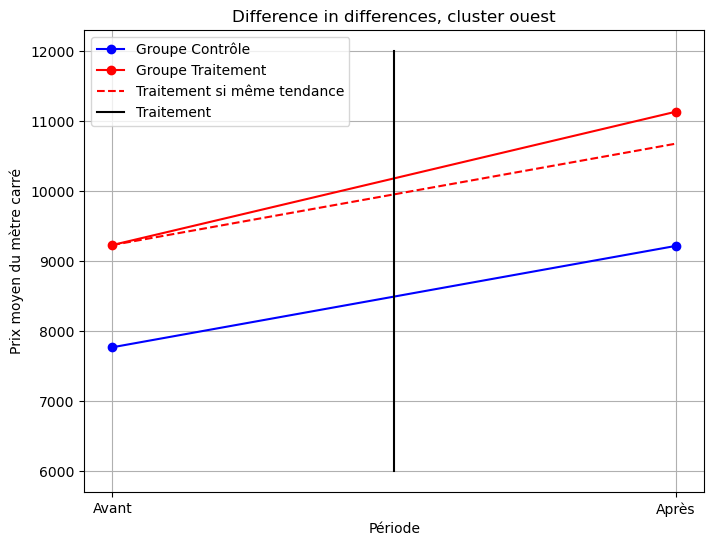

In [248]:
periode = ['Avant', 'Après']

# Création du graphique
plt.figure(figsize=(8, 6))

plt.plot(periode, [s1, s2], marker='o', label='Groupe Contrôle', color='blue')
plt.plot(periode, [p1, p2], marker='o', label='Groupe Traitement', color='red')
plt.plot(periode, [p1, p1 + (s2 - s1)], linestyle='--', label='Traitement si même tendance', color='red')
plt.plot([0.5, 0.5], [6000,12000], label='Traitement', color='black')


plt.xlabel('Période')
plt.ylabel('Prix moyen du mètre carré')
plt.title('Difference in differences, cluster ouest')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()

Et la valeur numérique : 

In [249]:
print((p2-p1)-(s2-s1))

456.5430822431563


On peut réaliser le même travail pour le cluster sud. 

In [250]:
crtl_sud = data_mut_sud_et_insee[data_mut_sud_et_insee['coddep'].isin(['92', '94'])]
trtm_sud = data_mut_sud_et_insee[data_mut_sud_et_insee['coddep']=='75']

In [251]:
crtl_sud['prix_m2'] = crtl_sud['valeurfonc'] / crtl_sud['stot']
trtm_sud['prix_m2'] = trtm_sud['valeurfonc'] / trtm_sud['stot']

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [252]:
cutoff_date = pd.to_datetime("2019-07-01")

crtl_sud['periode'] = crtl_sud['datemut'].apply(
    lambda x: 0 if x < cutoff_date else 1
)
s1 = crtl_sud[crtl_sud['periode']==0]['prix_m2'].mean()
s2 = crtl_sud[crtl_sud['periode']==1]['prix_m2'].mean()

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [253]:
trtm_sud['periode'] = trtm_sud['datemut'].apply(
    lambda x: 0 if x < cutoff_date else 1
)
p1 = trtm_sud[trtm_sud['periode']==0]['prix_m2'].mean()
p2 = trtm_sud[trtm_sud['periode']==1]['prix_m2'].mean()

/opt/conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


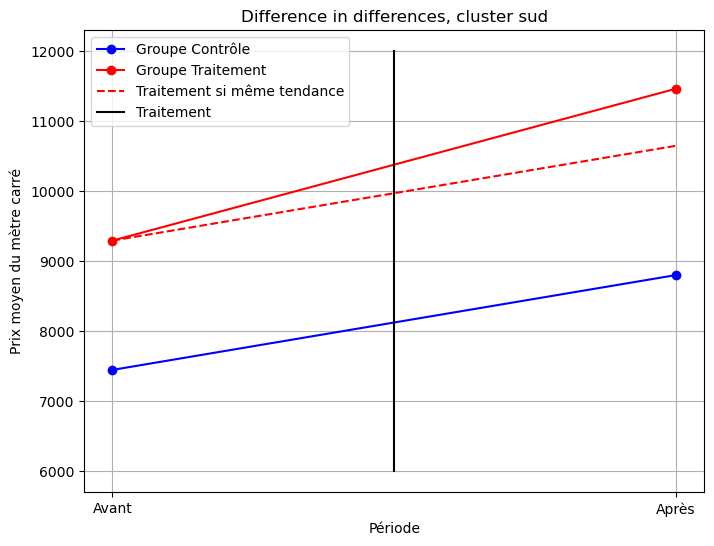

In [254]:
periode = ['Avant', 'Après']

# Création du graphique
plt.figure(figsize=(8, 6))

plt.plot(periode, [s1, s2], marker='o', label='Groupe Contrôle', color='blue')
plt.plot(periode, [p1, p2], marker='o', label='Groupe Traitement', color='red')
plt.plot(periode, [p1, p1 + (s2 - s1)], linestyle='--', label='Traitement si même tendance', color='red')
plt.plot([0.5, 0.5], [6000,12000], label='Traitement', color='black')


plt.xlabel('Période')
plt.ylabel('Prix moyen du mètre carré')
plt.title('Difference in differences, cluster sud')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()

In [255]:
print((p2-p1)-(s2-s1))

814.9949305988293


Ces deux résultats sont très contre-intuitifs : si l'hypothèse de même tendance tient, l'encadrement des loyers est donc lié à une augmentation du prix-moyen au mètre carré.


In [256]:
crtl_ouest = crtl_ouest[crtl_ouest['anneemut'].isin(["2021", '2020', '2019'])]
trtm_ouest = trtm_ouest[trtm_ouest['anneemut'].isin(["2021", '2020', '2019'])]

**2. Meilleure modélisation de la tendance**

On se réfère au modèle mathématique du DID présenté sur la page wikipédia en anglais(https://en.wikipedia.org/wiki/Difference_in_differences). 
L'une des raisons de nos résultats surprenants peut résider dans la limite principale du DID, qui est l'hypothèse de tendance similaire. Autrement dit, on observe directement s1, s2, p1, p2, donc il n'y a rien à changer de ce côté. Par contre, on observe pas Q, le prix moyen du mètre carré du groupe traitement s'il n'y avait pas eu de traitement. C'est ici qu'il y a une piste d'amélioration. 

Toute l'idée du modèle DID est de prédier l'évolution projetée du groupe traitement à partir de l'évolution observée du groupe contrôle. Mais on peut peut-être essayer une autre méthode, d'autant qu'on dispose de nombreuses variables INSEE que l'on n'a pas du tout exploitées. Pour reprendre le modèle de wikipedia, on a $ Q = \gamma_{s(2)} + \lambda_{2} + \epsilon_{2}$. Dans le cadre du DOD, on a fait comme si le $\lambda_t$ était purement indépendant des caractéristiques de chaque groupe. Mais on peut envisager les choses différement : on veut prédire $Q$ à partir des variables INSEE dont on dispose,  donc on veut $\lambda_t = X^T\beta$, où $X$ comprendra certaines variables INSEE. 

Comment déterminer ce $\beta$ ? L'objectif est d'obtenir la meilleure prédiction du prix moyen au mètre carré, sachant le jeu $(X_i, Y_i)_{i = 1, ..., n}$ et l'observation $Y_{n+1}$. On peut donc recourir à un estimateur LASSO. 

On ne peut pas simplement sélectionner toutes les variables INSEE, sinon on aurait une parfaite collinéarité entre certaines de nos covariables (par exemple, entre le nombre de femmes, le nombre d'hommes et le nombre d'habitants).

De plus, presque toutes les variables INSEE sont des quantités, et non des taux en proportion de la population de l'IRIS. En conséquence, la densité dans un IRIS peut brouiller l'effet d'une variable sur le prix moyen au mètre carré. On va donc commencer par forger les covariables que l'on souhaite utiliser : des taux non parfaitement collinéaires entre eux.

In [272]:
data_mut_ouest_et_insee['prix_m2'] = data_mut_ouest_et_insee['valeurfonc'] / data_mut_ouest_et_insee['stot']
data_mut_ouest_et_insee['prop_h'] = data_mut_ouest_et_insee['P_H1564'] / data_mut_ouest_et_insee['P_POP1564']
data_mut_ouest_et_insee['tx_chom'] = data_mut_ouest_et_insee['P_CHOM1564'] / data_mut_ouest_et_insee['P_ACT1564']
data_mut_ouest_et_insee['prop_ht_diplome'] = data_mut_ouest_et_insee['C_ACT1564_CS3'] / data_mut_ouest_et_insee['P_ACT1564']
data_mut_ouest_et_insee['prop_maison'] = data_mut_ouest_et_insee['P_MAISON'] / data_mut_ouest_et_insee['P_LOG']
data_mut_ouest_et_insee['prop_res_princ'] = data_mut_ouest_et_insee['P_RP'] / data_mut_ouest_et_insee['P_LOG']

list_covar = ['prop_h', 'tx_chom',"prop_ht_diplome", "prop_maison", "prop_res_princ"] #"DISP_MED"

On va également s'assurer de pouvoir utiliser le revenu médian (il faut transformer la variable en type numérique).

In [273]:
print(len(data_mut_ouest_et_insee))
def est_un_nombre(valeur):
    try:
        a = str(valeur).replace(',', ".")
        float(a)
        return True
    except ValueError:
        return False

data_mut_ouest_et_insee = data_mut_ouest_et_insee[data_mut_ouest_et_insee['DISP_MED'].apply(est_un_nombre)]
data_mut_ouest_et_insee['DISP_MED'] = data_mut_ouest_et_insee['DISP_MED'].astype(float)

77368


On peut maintenant créer notre jeu de données, c'est-à-dire l'échantillon $(X_i, Y_i)_{i = 1, ..., n}$ . Puisque la prédiction Q ne doit pas prendre en compte l'effet du traitement, on doit écarter toutes les observations du groupe traitement postérieures au traitement. On peut également exclure toutes les observations du groupe contrôle. En effet, ce dernier ne servait qu'à avoir obtenir $Q sous l'hypothèse de même tendance entre les deux zones. Maintenant que l'on cherche à prédire $Q$ par une régression, inclure le groupe contrôle ne ferait que brouiller les données, car en réalité il existe très probablement des tendances différentes entre les arrondissements parisiens et les villes de banlieues. 

In [274]:
cutoff_date = pd.to_datetime("2019-07-01")

data_mut_ouest_et_insee['periode'] = data_mut_ouest_et_insee['datemut'].apply(
    lambda x: 0 if x < cutoff_date else 1
)

df_lasso_ouest = data_mut_ouest_et_insee[data_mut_ouest_et_insee['periode']==0]
df_lasso_ouest = df_lasso_ouest[df_lasso_ouest['coddep']=='75']
X = df_lasso_ouest[list_covar]
Y = df_lasso_ouest['prix_m2']

Et on va produire l'observation $X_{n+1}$ de nos covariables : puisque $Y_{n+1}$ correspond au prix *moyen* du mètre carré, on doit utiliser la moyenne des covariables pour les observations après traitement.

In [275]:
df_new_obs = data_mut_ouest_et_insee[data_mut_ouest_et_insee['periode']==1]
df_new_obs = df_new_obs[df_new_obs['coddep']=='75']
X_new = pd.DataFrame(df_new_obs[list_covar].mean()).T
Y_new_obs = df_new_obs['prix_m2'].mean()

On sépare maintenant nos données en jeux d'entraînement et de test : 

In [276]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

On doit ensuite normaliser nos données.

In [277]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_new_scaled = scaler.transform(X_new)

In [278]:
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, Y_train)

LassoCV(cv=5, random_state=42)

On peut regarder le $R^2$ de la régression que l'on obtient avec cet estimateur LASSO. 

In [279]:
print(lasso_cv.score(X_test_scaled, Y_test))

0.03671208357142741


La régression réalisée est donc extrêmement mauvaise (nos covariables sont très peu utiles pour prédire le prix du mètre carré). Regardons quand même la valeur qu'on obtient pour $Q$ : 

In [280]:
Y_new = lasso_cv.predict(X_new_scaled)
print(Y_new)
print(Y_new_obs)

[9470.97751578]
11120.765751503604


Comparons avec le $Q$ obtenu dans le DID : 

In [282]:
print(p1 + (s2 - s1))

10649.247279535302


Manifestement, le DID reste une meilleure méthode de projection de $Q$ que l'estimateur LASSO. 

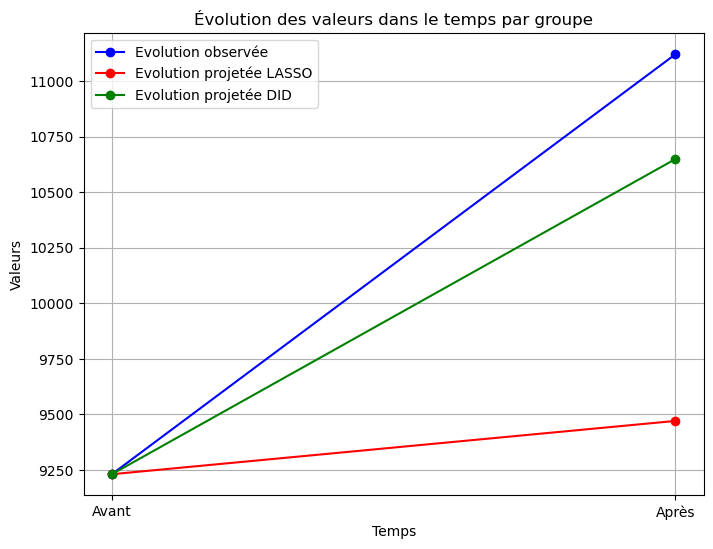

In [283]:
import matplotlib.pyplot as plt

periode = ['Avant', 'Après']
dprt = df_lasso_ouest['prix_m2'].mean()

# Création du graphique
plt.figure(figsize=(8, 6))

# Tracer les valeurs du groupe 1
plt.plot(periode, [dprt, Y_new_obs ], marker='o', label='Evolution observée', color='blue')

# Tracer les valeurs du groupe 2
plt.plot(periode, [dprt, Y_new[0]], marker='o', label='Evolution projetée LASSO', color='red')
plt.plot(periode, [dprt, p1 + (s2 - s1)], marker='o', label='Evolution projetée DID', color='green')


# Ajouter des labels et un titre
plt.xlabel('Temps')
plt.ylabel('Valeurs')
plt.title('Évolution des valeurs dans le temps par groupe')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()


Les seuls résultats exploitables proviennent donc du DID : l'encadrement des loyers conduirait à une hausse du prix du mètre carré. Ce résultat n'est cependant pas complètement absurde : certaines études économiques ont montré que l'encadrement des loyers réduit l'offre de logements disponibles, ce qui peut avoir deux effets : 
- le loyer moyen augmente, ce qui encourage à investir plus dans l'immobilier dans la zone, et donc mène à une hausse des prix du mètre carré ; 
- face au rationnement de l'offre locative, les ménages souhaitant s'installer dans la zone se redirigent vers l'achat, conduisant à une hausse du prix du mètre carré. 

Il s'agît là de deux pistes d'explications, qu'il faudrait explorer. Quant au travail que nous avons réalisé, il ne s'avère finalement pas très concluant.